In [3]:
#%matplotlib nbagg
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 140
plt.rcParams.update({'font.size': 12})

# 8 The Lapped Bi-orthogonal Transform (LBT)

<div class="alert alert-warning alert-block">
    
This notebook is incomplete!</div>

<p></p>

<!-- sorry for the nasty HTML, markdown is bad for figures -->

<figure style="text-align: center">
<div class="row">
<figure class="col-md-4 col-md-offset-1">
<img src="figures/lbt.png" style="max-height: 350px" />
<figcaption>(a) Lapped Bi-orthogonal Transform</figcaption>
</figure>

<figure class="col-md-5 col-md-offset-1">
<img src="figures/pot.png" style="max-height: 350px" />
<figcaption>(b) Photo Overlap Transform and a DCT</figcaption>
</figure>
</div>
<div class="row">
<figcaption>
<br />

Figure 4: (a) An LBT transforms overlapping sections of `X` to create `Y`. (b) In some cases
this can be interpreted as pre-filtering with a POT, followed by a DCT.</figcaption></div></figure>

One of the difficulties with the DCT is that it processes each block separately and hence
does not take advantage of any correlation between blocks. A possible solution to this is
to use a _Lapped Bi-orthogonal Transform (LBT)_. These transform overlapping blocks in `X`
to generate smaller non-overlapping blocks in `Y`. In the left-hand figure above, 16 values
in `X` are used to generate each set of 8 values in `Y`.

LBTs are quite complicated to derive and analyse: however one of the most popular forms<sup>3</sup>
can also be represented as a pre-filtering operation before performing the DCT described
in the previous section.
In this case the pre-filtering (or post-filtering for the reverse
operation) is sometimes known as a _Photo Overlap Transform or POT_. A POT followed
by a DCT is then equivalent to a particular type of LBT.

The right-hand figure above demonstrates this. The POT is first performed on a section
of data `X`, shifted by `N/2`, so that it runs across the block boundaries of the subsequent
DCT. Ignoring this block shift for a moment, the forward operation for a 2D image `X` is:


$$Y = C ∗ Pf ∗ X ∗ Pf ′ ∗ C′$$

or in reverse

$$ X = Pr′ ∗ C′ ∗ Y ∗ C ∗ Pr $$

<hr />
<small><sup>3</sup>The type-II fast lapped (bi-)orthogonal transform, or LOT-II</small>

## 8.1 Applying the LBT to images

In [4]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

The pre-filtering `Pf ∗ X ∗ Pf′` (with the correct block shift) is straightforward in Python:

```python
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
```

This is followed by the DCT `C` as before. In the reverse operation, the inverse DCT `C’` is
performed first, followed by Pr’:
```python
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
```

We have provided a function `pot_ii(N, s)` which will generate a forward (pre-filtering,
`Pf`) and reverse (post-filtering, `Pr`) matrix of size `N` with scaling factor `s`.

In [5]:
from cued_sf2_lab.lbt import pot_ii
from cued_sf2_lab.dct import colxfm
from cued_sf2_lab.dct import dct_ii

Edit your code
for performing DCT analysis so that it can pre-filter `X` with `Pf` before the forward DCT,
then post-filter `Z` with `Pr` after the inverse DCT. Confirm that, without quantisation, this
correctly recreates the original image, i.e. `Zp = X`. Use `Pf, Pr = pot_ii(N)` with the
default scaling value `s`.

In [6]:
C8 = dct_ii(8)

Y = colxfm(colxfm(X, C8).T, C8).T
Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)

np.allclose(X,Z)

True

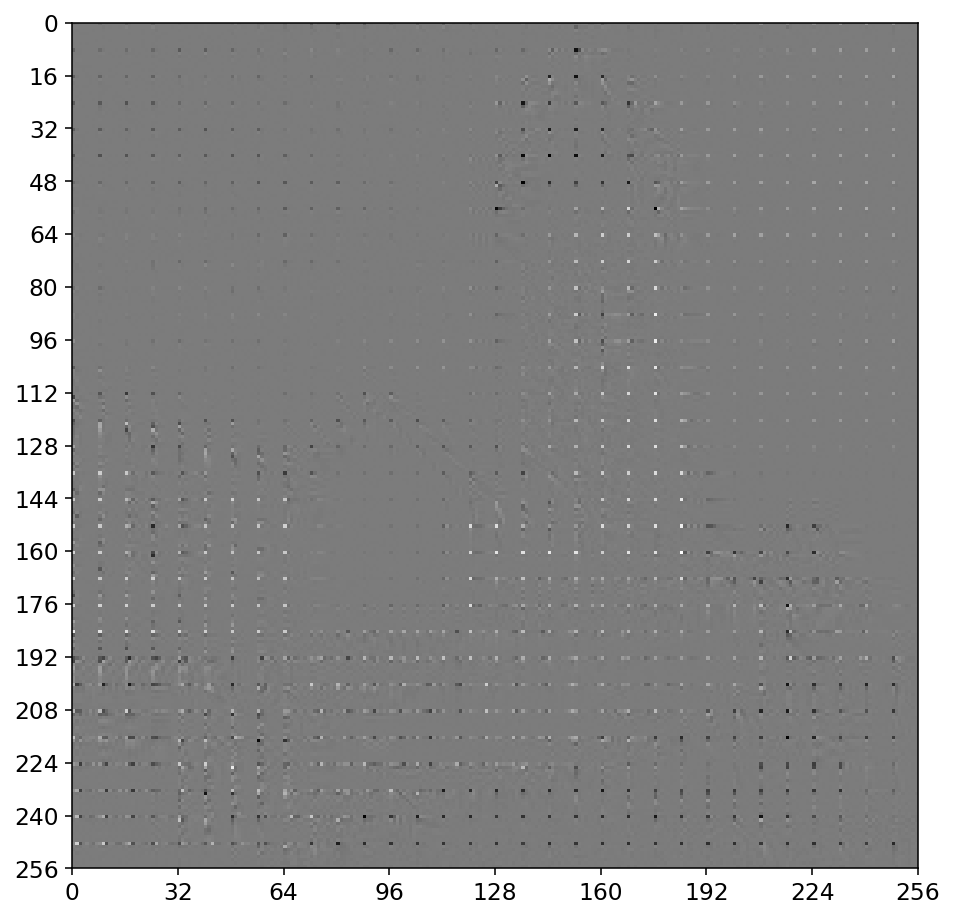

In [7]:
N = 8

C = dct_ii(N)
Pf, Pr = pot_ii(N)

t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

Y = colxfm(colxfm(Xp, C).T, C).T
fig, ax = plt.subplots()
plot_image(Y, ax=ax)

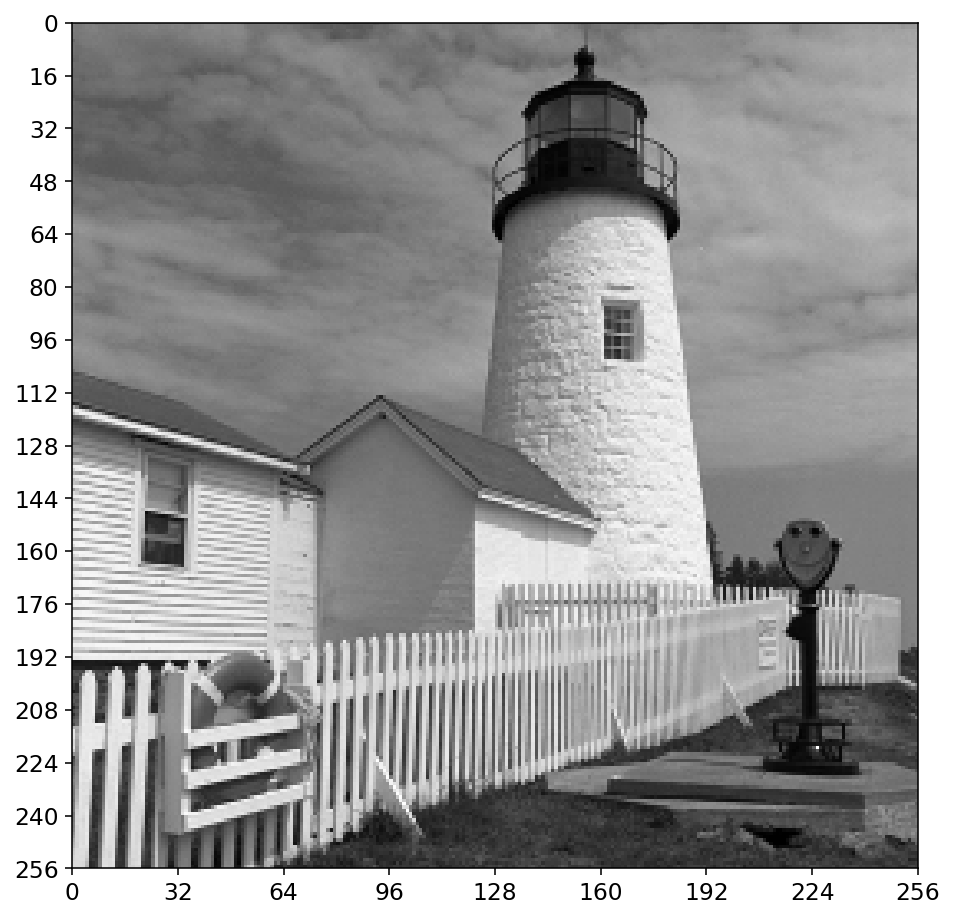

In [8]:
Z = colxfm(colxfm(Y.T, C.T).T, C.T)
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)

fig, ax = plt.subplots()
plot_image(Zp, ax=ax)

In [26]:
np.allclose(X, Zp)

True

## 8.2 Quantisation and coding efficiency

The scaling factor `s` determines the degree of bi-orthogonality. If `s = 1` then Pf is the same
as Pr, otherwise `1 < s < 2` weights the relative contributions of `Pf` and `Pr` un-equally.

<div class="alert alert-block alert-danger">

For an 8 × 8 DCT, try implementing an LBT with POT scaling factors varying from $1$
to $2$ ($\sqrt{2}$ is often a good choice). In each case find the quantisation step which makes
the rms error match the directly quantised image. Note the compression ratios and find
the scaling factor which maximises these. Also note the visual features in these images.</div>

In [9]:
from cued_sf2_lab.laplacian_pyramid import bpp
from cued_sf2_lab.laplacian_pyramid import quantise

from scipy.optimize import minimize_scalar

def dctbpp(Yr, N):
    nbits = 0
    L = int(256/N)
    npixels = L**2
    for i in range(N):
        for j in range(N):
            subimage = Yr[i*L:(i+1)*L, j*L:(j+1)*L]
            nbits += bpp(subimage)*npixels
    return nbits

In [10]:
def optimise_step(Y, C, Pf, Pr,t):
    def rms_error(stepsize):
        Yq = quantise(Y, stepsize)
        
        Z = colxfm(colxfm(Yq.T, C.T).T, C.T)
        Zp = Z.copy()  #copy the non-transformed edges directly from Z
        Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
        Zp[t,:] = colxfm(Zp[t,:], Pr.T)
        
        return np.abs(np.std(Zp-X)-np.std(quantise(X,17)-X))
    
    res = minimize_scalar(rms_error, method='bounded', bounds=(5,50))
    
    return res

In [11]:
def LBT(s, N=8):
    C = dct_ii(N)
    Pf, Pr = pot_ii(N, s=s)
    
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

    Y = colxfm(colxfm(Xp, C).T, C).T
    
    stepsize = optimise_step(Y,C,Pf,Pr,t).x
    Yq = quantise(Y, stepsize)
    
    Z = colxfm(colxfm(Yq.T, C.T).T, C.T)
    Zp = Z.copy()  #copy the non-transformed edges directly from Z
    Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:], Pr.T)
    
    compression_ratio = dctbpp(quantise(X, 17), N)/dctbpp(Yq, N)
    
    print(f"Stepsize: {stepsize}")
    print(f"Compression ratio: {compression_ratio}")
    return stepsize, compression_ratio, Zp

s = 1
Stepsize: 23.369714600026022
Compression ratio: 1.920791067283545
s = 1.2845
Stepsize: 25.38225102379783
Compression ratio: 1.9687712626961857
s = 2
Stepsize: 26.444761578410372
Compression ratio: 1.76589494122451


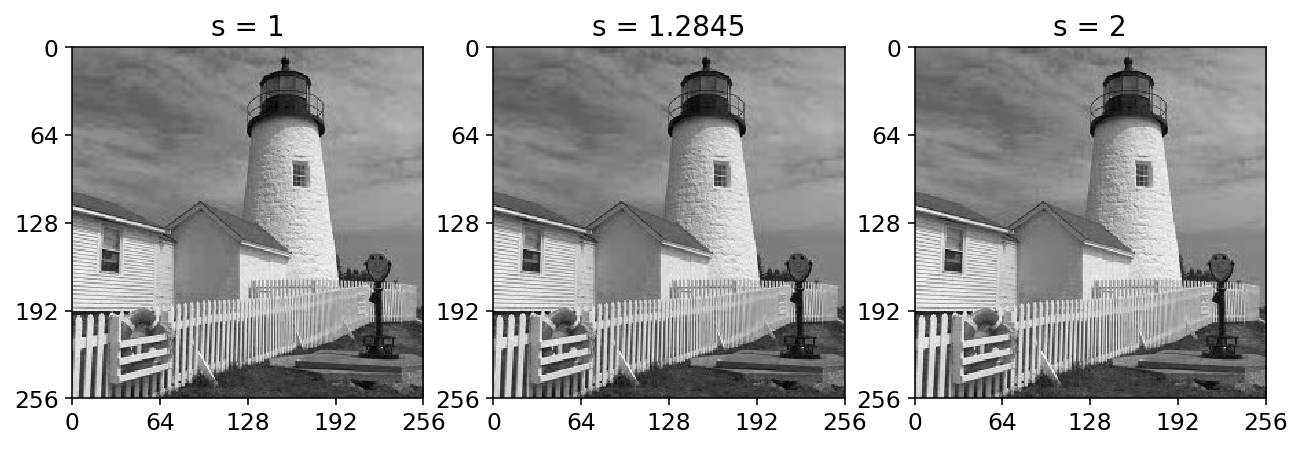

In [13]:
s_arr = [1, 1.2845, 2]
fig, axs = plt.subplots(ncols=len(s_arr), figsize=(11,11))

for i, s in enumerate(s_arr):
    print(f"s = {s}")

    stepsize, compression_ratio, Zp = LBT(s)
    plot_image(Zp, ax=axs[i])
    axs[i].set_title(f"s = {s}")

In [19]:
def optimise_s(s):
    return -LBT(s)[1]

res = minimize_scalar(optimise_s, bounds=(1,2), method='bounded')

Stepsize: 25.794798616268412
Compression ratio: 1.9604746012416727
Stepsize: 26.411268829826444
Compression ratio: 1.9146679910292843
Stepsize: 25.076827634578457
Compression ratio: 1.9664102001838868
Stepsize: 25.213449366400237
Compression ratio: 1.967467694901232
Stepsize: 25.352349639760458
Compression ratio: 1.968065080239634
Stepsize: 25.53800458198653
Compression ratio: 1.9679734110040852
Stepsize: 25.424626139336784
Compression ratio: 1.967048748521528
Stepsize: 25.299200924211668
Compression ratio: 1.9678687500181014
Stepsize: 25.39320824466278
Compression ratio: 1.968129110725496
Stepsize: 25.395857253006728
Compression ratio: 1.9671569117181078
Stepsize: 25.37986399364881
Compression ratio: 1.9687649915121093
Stepsize: 25.375517942965903
Compression ratio: 1.968574960318931
Stepsize: 25.381856856116304
Compression ratio: 1.9686932901081509
Stepsize: 25.38001761562522
Compression ratio: 1.9687649915121093
Stepsize: 25.38224305472095
Compression ratio: 1.9687712626961857
Steps

In [21]:
s_max = res.x
res

     fun: -1.9687712626961857
 message: 'Solution found.'
    nfev: 18
  status: 0
 success: True
       x: 1.284508111186429

The POT can often improve both compression and block smoothing, since the pre-filter
acts to reduce correlations between each DCT sub-block, whilst the inverse post-filter
acts to remove the discontinuities between sub-blocks. This is rather different from the
operation of the DCT. Investigate this by looking at the basis functions, as you did with
the DCT:

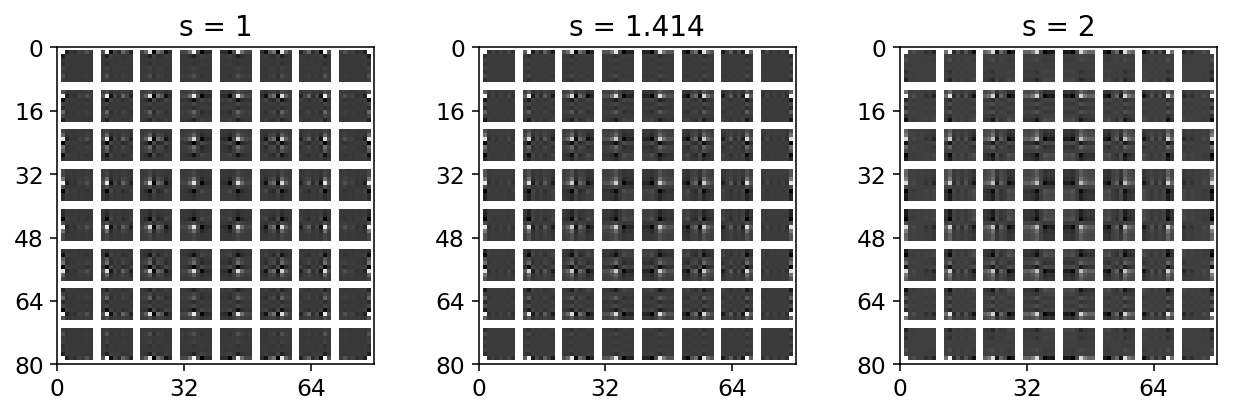

In [24]:
s_arr = [1, 1.414, 2]
fig, axs = plt.subplots(ncols=len(s_arr), figsize=(11,3))

N = 8

for i, s in enumerate(s_arr):
    Pf, Pr = pot_ii(N, s=s)
    bases = np.concatenate([np.full((N,1), np.nan), Pf, np.full((N,1), np.nan)], axis=1)
    bases = bases.reshape(-1, 1)
    
    im_obj = plot_image(bases @ bases.T, ax=axs[i])

    #fig.colorbar(im_obj, ax=axs[i]);
    axs[i].set_title(f"s = {s}")

<div class="alert alert-block alert-danger">

Look at both these bases and the pre-filtered image `Xp`, using different scaling factors
`s`, and comment on the visual effect of varying these scaling factors. You may need to
multiply `Xp` by up to 0.5 to display it better.</div>

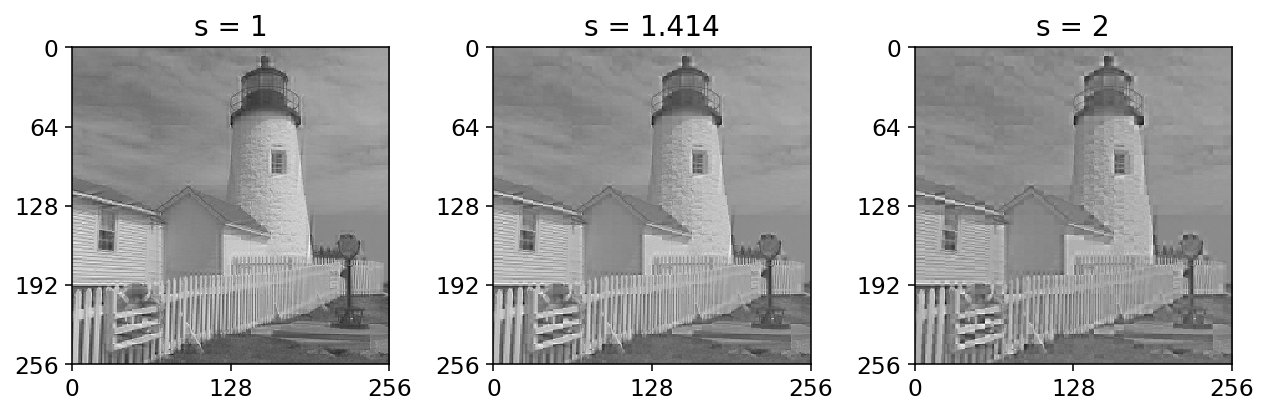

In [17]:
s_arr = [1, 1.414, 2]
fig, axs = plt.subplots(ncols=len(s_arr), figsize=(11,3))

N = 8

for i, s in enumerate(s_arr):
    Pf, Pr = pot_ii(N, s=s)
    
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
    
    plot_image(Xp, ax=axs[i])
    
    axs[i].set_title(f"s = {s}")

With this type of POT / DCT combination it is common to use smaller DCT block sizes
but to code several blocks together. Hence a more accurate estimate of the number of bits
is found by always using 16 × 16 blocks, i.e. regroup `Yq` with the correct size `N` to give
`Yr`, but then always use `dctbpp(Yr, 16)`.

<div class="alert alert-block alert-danger">

Investigate the relative visual and compression performance of LBTs with 4 × 4, 8 × 8
and 16 × 16 blocks, using the scaling factor you have previously selected. As before, be
careful to match the rms error with a directly quantised image.</div>

In [25]:
%matplotlib qt
s = res.x
fig, axs = plt.subplots(ncols=3, figsize=(11,11), sharex=True, sharey=True)

for i, N in enumerate([4,8,16]):
    stepsize, compression_ratio, Zp = LBT(s, N=N)
    
    plot_image(Zp, ax=axs[i])
    axs[i].set_title(f"n = {N}")
    

Stepsize: 27.636046055778447
Compression ratio: 1.969659583746986
Stepsize: 25.382284020876625
Compression ratio: 1.9687712626961857
Stepsize: 22.7284237707815
Compression ratio: 1.6133983426733456
